## Simulating a surface code memory experiment

In [86]:
from typing import List
from dataclasses import dataclass
from math import log10
import numpy as np
import matplotlib.pyplot as plt
import stim
import pymatching

# With `stim`

Let's do a transversal initialization, followed by phenomenological depolarizing noise, and then a single round of syndrome extraction. Decode with `PyMatching`, then get the logical error rate.

In [87]:
# See the stim tutorial!
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(4, 0) 4
    QUBIT_COORDS(0, 1) 5
    QUBIT_COORDS(1, 1) 6
    QUBIT_COORDS(2, 1) 7
    QUBIT_COORDS(3, 1) 8
    QUBIT_COORDS(4, 1) 9
    QUBIT_COORDS(0, 2) 10
    QUBIT_COORDS(1, 2) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(3, 2) 13
    QUBIT_COORDS(4, 2) 14
    QUBIT_COORDS(0, 3) 15
    QUBIT_COORDS(1, 3) 16
    QUBIT_COORDS(2, 3) 17
    QUBIT_COORDS(3, 3) 18
    QUBIT_COORDS(4, 3) 19
    QUBIT_COORDS(0, 4) 20
    QUBIT_COORDS(1, 4) 21
    QUBIT_COORDS(2, 4) 22
    QUBIT_COORDS(3, 4) 23
    QUBIT_COORDS(4, 4) 24
    R 0 2 4 6 8 10 12 14 16 18 20 22 24 1 3 5 7 9 11 13 15 17 19 21 23
    TICK
    DEPOLARIZE1(0.1) 0 2 4 6 8 10 12 14 16 18 20 22 24
    H 1 3 11 13 21 23
    TICK
    CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
    TICK
    CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9 24 19
    TICK
    CX 11 6 21 16 13 8 23 18 0 5 10 15 2

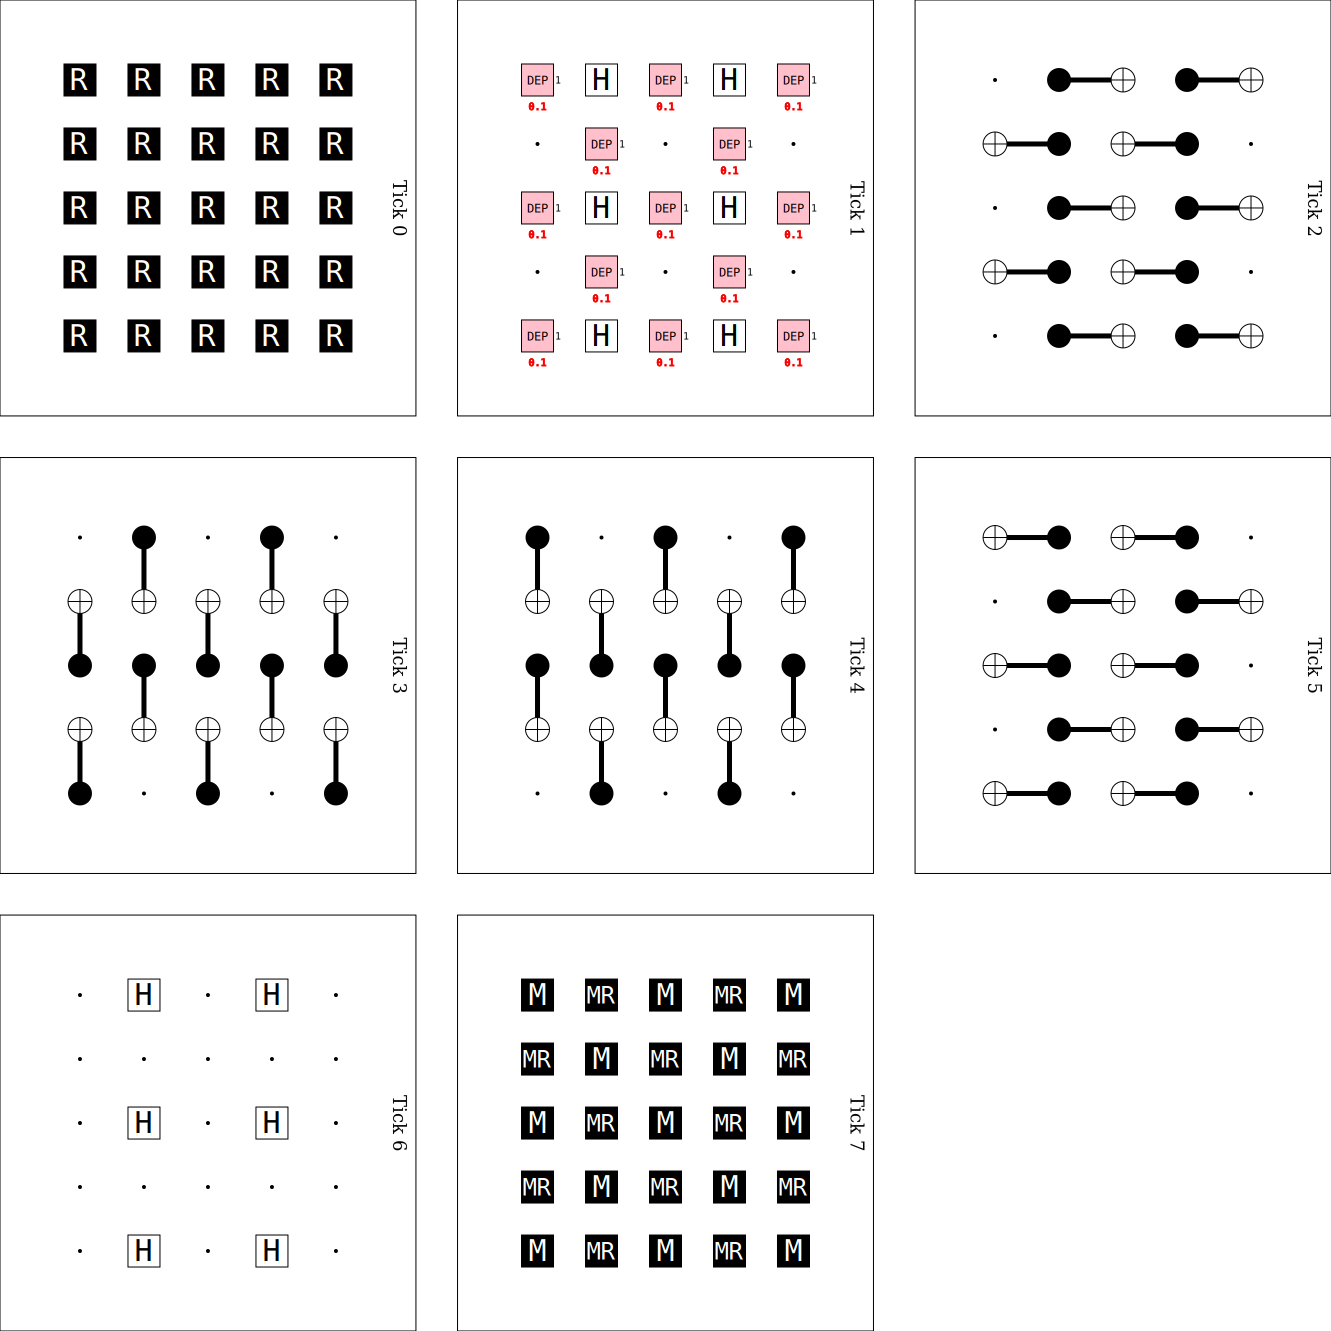

In [106]:
d = 3
noise = 0.1
circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=1, distance=d,
    before_round_data_depolarization=noise,
    before_measure_flip_probability=0.
)
print(repr(circuit))
circuit.diagram('timeslice-svg')

In [89]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0666667) D0 D1
    error(0.0666667) D0 D2
    error(0.0666667) D0 L0
    error(0.0666667) D1
    error(0.0666667) D1 D3
    error(0.0666667) D2 D3
    error(0.0666667) D2 D4
    error(0.0666667) D2 L0
    error(0.0666667) D3
    error(0.0666667) D3 D5
    error(0.0666667) D4 D5
    error(0.0666667) D4 L0
    error(0.0666667) D5
    detector(0, 1, 0) D0
    detector(0, 3, 0) D1
    detector(2, 1, 0) D2
    detector(2, 3, 0) D3
    detector(4, 1, 0) D4
    detector(4, 3, 0) D5
    detector(0, 1, 1) D6
    detector(0, 3, 1) D7
    detector(2, 1, 1) D8
    detector(2, 3, 1) D9
    detector(4, 1, 1) D10
    detector(4, 3, 1) D11
''')


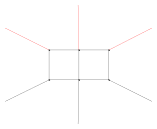

In [90]:
dem.diagram("matchgraph-svg")

In [91]:
shots = 100_000
ds = [3, 5, 7]
noise_rates = np.logspace(log10(0.125), log10(0.2), num=10)
lers = np.zeros((len(ds), len(noise_rates)), dtype=float)

for i, d in enumerate(ds):
    for j, noise in enumerate(noise_rates):
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=1, distance=d,
            before_round_data_depolarization=noise,
            before_measure_flip_probability=0.
        )
        num_errors = count_logical_errors(circuit, shots)
        ler = float(num_errors) / shots
        lers[i, j] = ler

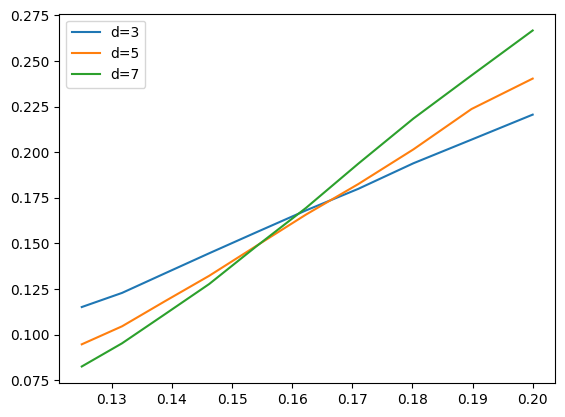

In [92]:
fig, ax = plt.subplots()
for i, d in enumerate(ds):
    ax.plot(noise_rates, lers[i, :], label=f"d={d}")
ax.legend()

# With my own circuit

In [93]:
def binary_np_array_to_str(arr: np.ndarray) -> str:
    """Convert a binary numpy array (one-dimensional) to a string,
    e.g. [True, False, True] -> '101'."""

    assert len(arr.shape) == 1
    return ''.join('1' if b else '0' for b in arr)

In [94]:
def z_measurement_gadget(measure_qubit: int, system_qubits: List[int]) -> stim.Circuit:
    """Get a circuit that measures an Z-type Pauli string."""

    ckt = stim.Circuit()
    ckt.append("R", measure_qubit)
    for sq in system_qubits:
        ckt.append("CX", [sq, measure_qubit])
    ckt.append("MR", measure_qubit)
    return ckt


def x_measurement_gadget(measure_qubit: int, system_qubits: List[int]) -> stim.Circuit:
    """Get a circuit that measures an X-type Pauli string."""

    ckt = stim.Circuit()
    ckt.append("R", measure_qubit)
    ckt.append("H", measure_qubit)
    for sq in system_qubits:
        ckt.append("CX", [measure_qubit, sq])
    ckt.append("H", measure_qubit)
    ckt.append("MR", measure_qubit)
    return ckt


@dataclass
class CodeStabilizer:
    """Representation of a stabilizer along with its measurement qubit."""

    type: str
    measure_qubit: int
    data_qubits: List[int]

    def __repr__(self) -> str:
        return f"{self.type}-type stabilizer with measure qubit {self.measure_qubit} and data qubits {self.data_qubits}."

    def to_circuit(self) -> stim.Circuit:
        """Build a measurement circuit for the stabilizer."""

        if self.type == "X":
            return x_measurement_gadget(self.measure_qubit, self.data_qubits)
        elif self.type == "Z":
            return z_measurement_gadget(self.measure_qubit, self.data_qubits)
        else:
            raise ValueError(f"Stabilizer has unknown type {self.type}.")


class SurfaceCode:

    def __init__(self, d: int):
        self._d = d
        self._z_stabilizers: List[CodeStabilizer] = []
        self._x_stabilizers: List[CodeStabilizer] = []

        qubits_per_side = 2 * d - 1
        for i in range(qubits_per_side):
            for j in range(qubits_per_side):
                qubit_idx = i * qubits_per_side + j
                if (i % 2 == 0 and j % 2 != 0) or (i % 2 != 0 and j % 2 == 0):
                    # This is a measurement qubit.
                    if i % 2 == 0 and j % 2 != 0:
                        stab_type = "Z"
                    else:
                        stab_type = "X"
                    # The data qubits are the nearest neighbors of this one.
                    data_qubits: List[int] = []
                    if i != 0:
                        # North qubit.
                        data_qubits.append((i - 1) * qubits_per_side + j)
                    if i != qubits_per_side - 1:
                        # South qubit.
                        data_qubits.append((i + 1) * qubits_per_side + j)
                    if j != 0:
                        # West qubit
                        data_qubits.append(i * qubits_per_side + j-1)
                    if j != qubits_per_side - 1:
                        # East qubit
                        data_qubits.append(i * qubits_per_side + j+1)
                    if stab_type == "Z":
                        self._z_stabilizers.append(CodeStabilizer(stab_type, qubit_idx, data_qubits))
                    else:
                        self._x_stabilizers.append(CodeStabilizer(stab_type, qubit_idx, data_qubits))
    
    @property
    def x_stabilizers(self) -> List[CodeStabilizer]:
        return self._x_stabilizers

    @property
    def z_stabilizers(self) -> List[CodeStabilizer]:
        return self._z_stabilizers

    def qubits(self, which: str="all") -> List[int]:
        """Get a list of all qubits in the code, data and measurement alike.
        
        Arguments:
        which - str that decides which qubits to get. Should be one of
        'data', 'measure', or 'all'."""

        assert which in ["all", "measure", "data"]

        qubit_list: List[int] = []
        for stabilizer in self._z_stabilizers + self._x_stabilizers:
            if which == "all" or which == "measure":
                qubit_list.append(stabilizer.measure_qubit)
            if which == "all" or which == "data":
                qubit_list += stabilizer.data_qubits
        return sorted(list(set(qubit_list)))
    
    @property
    def logical_x(self) -> stim.PauliString:
        """The logical X operator of the code. See Fowler Fig. 3."""

        qubits_per_side = 2 * self._d - 1
        qubit_coords = [(0, 2 * i) for i in range(self._d)]
        qubit_inds = [i * qubits_per_side + j for i, j in qubit_coords]
        pauli_spec = "+"
        for q in self.qubits("all"):
            if q in qubit_inds:
                pauli_spec += "X"
            else:
                pauli_spec += "_"
        return stim.PauliString(pauli_spec)

    @property
    def logical_z(self) -> stim.PauliString:
        """The logical Z operator of the code. See Fowler Fig. 3."""

        qubits_per_side = 2 * self._d - 1
        qubit_coords = [(2 * i, 0) for i in range(self._d)]
        qubit_inds = [i * qubits_per_side + j for i, j in qubit_coords]
        pauli_spec = "+"
        for q in self.qubits("all"):
            if q in qubit_inds:
                pauli_spec += "X"
            else:
                pauli_spec += "_"
        return stim.PauliString(pauli_spec)
    
    @property
    def coords_circuit(self) -> stim.Circuit:
        """A circuit that assigns coordinates to the qubits for 2D visualization."""

        ckt = stim.Circuit()
        qubits_per_side = 2 * d - 1
        for i in range(qubits_per_side):
            for j in range(qubits_per_side):
                qubit_idx = i * qubits_per_side + j
                ckt.append_from_stim_program_text(f"QUBIT_COORDS({i},{j}) {qubit_idx}")
        return ckt

In [95]:
d = 3
code = SurfaceCode(d)
print(code.qubits)

for x_stabilizer in code.x_stabilizers:
    print(x_stabilizer)
for z_stabilizer in code.z_stabilizers:
    print(z_stabilizer)

<bound method SurfaceCode.qubits of <__main__.SurfaceCode object at 0x110322750>>
X-type stabilizer with measure qubit 5 and data qubits [0, 10, 6].
X-type stabilizer with measure qubit 7 and data qubits [2, 12, 6, 8].
X-type stabilizer with measure qubit 9 and data qubits [4, 14, 8].
X-type stabilizer with measure qubit 15 and data qubits [10, 20, 16].
X-type stabilizer with measure qubit 17 and data qubits [12, 22, 16, 18].
X-type stabilizer with measure qubit 19 and data qubits [14, 24, 18].
Z-type stabilizer with measure qubit 1 and data qubits [6, 0, 2].
Z-type stabilizer with measure qubit 3 and data qubits [8, 2, 4].
Z-type stabilizer with measure qubit 11 and data qubits [6, 16, 10, 12].
Z-type stabilizer with measure qubit 13 and data qubits [8, 18, 12, 14].
Z-type stabilizer with measure qubit 21 and data qubits [16, 20, 22].
Z-type stabilizer with measure qubit 23 and data qubits [18, 22, 24].


## Preparing a surface code state

In "A game of surface codes," Fowler asserts that you can initialize a surface code qubit in the $\ket{0_L}$ or $\ket{+_L}$ states by setting every data qubit to $\ket{0}$ or $\ket{+}$ and then measuring all the code stabilizers. Let's test this out!

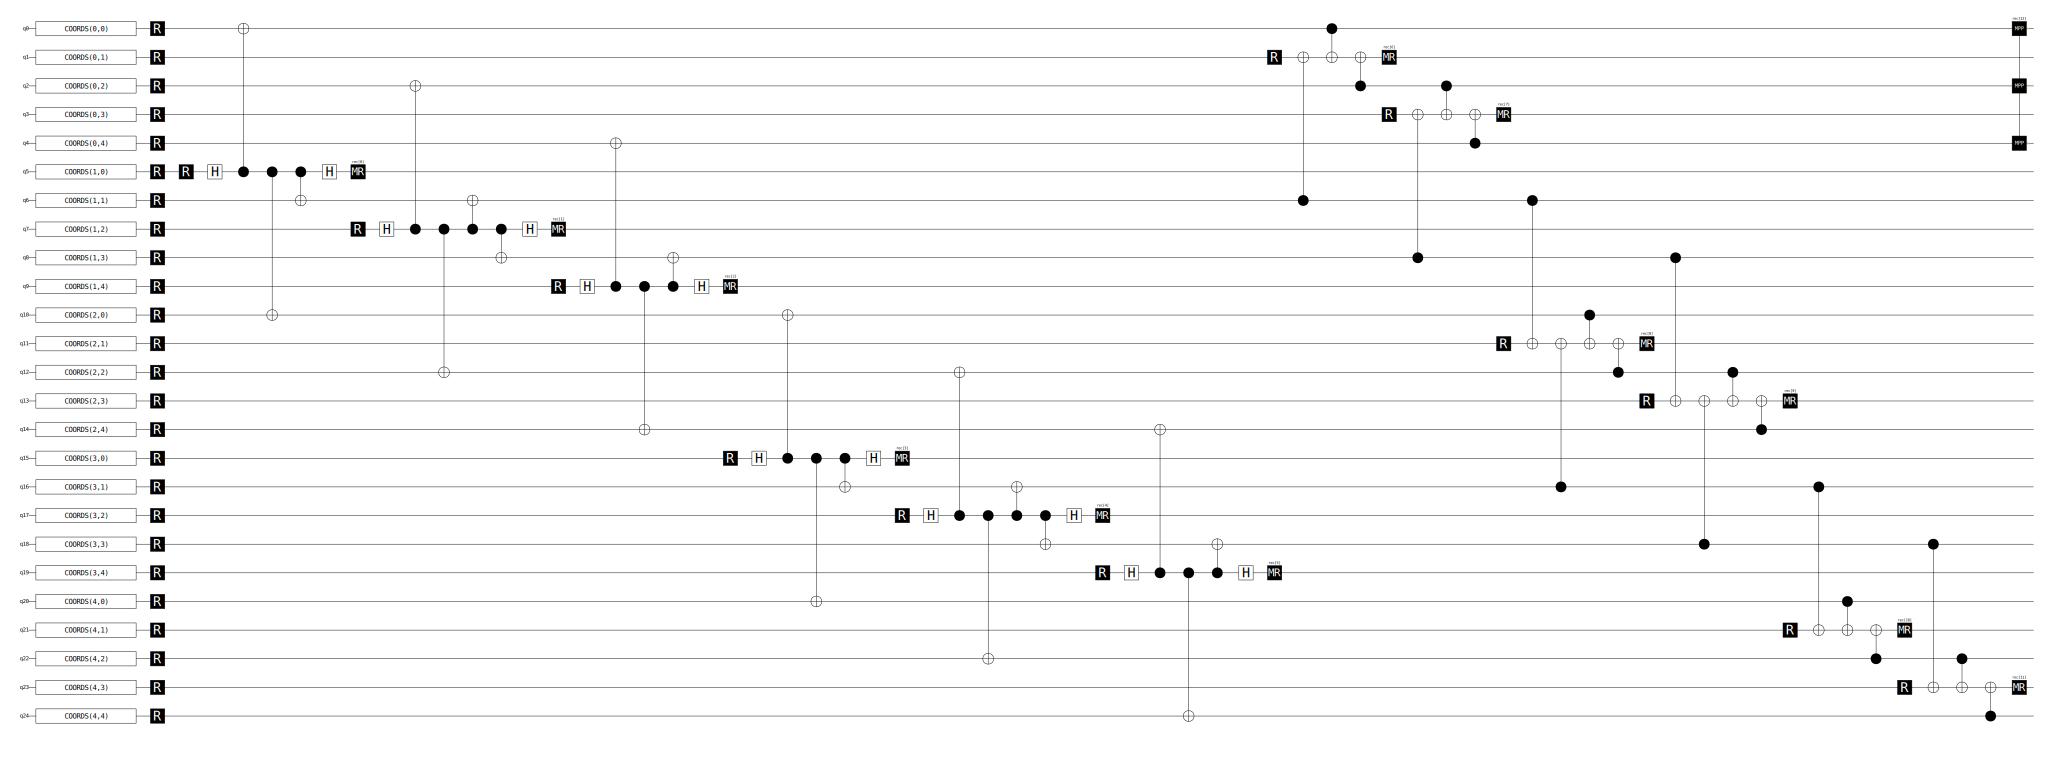

In [96]:
state_to_prepare = "0" # '0' or '+'
pauli_to_measure = "X" # 'Z' or 'X'.

prep_ckt = stim.Circuit()
prep_ckt += code.coords_circuit
for qubit in code.qubits("all"):
    prep_ckt.append("R", qubit)
    if state_to_prepare == '+':
        prep_ckt.append("H", qubit)
# Measure all stabilizers.
for x_stabilizer in code.x_stabilizers:
    prep_ckt += x_stabilizer.to_circuit()
for z_stabilizer in code.z_stabilizers:
    prep_ckt += z_stabilizer.to_circuit()
if pauli_to_measure == "Z":
    z_bar = code.logical_z
    measure_text = '*'.join(['Z' + str(idx) for idx in z_bar.pauli_indices()])
    prep_ckt.append_from_stim_program_text(f"MPP {measure_text}")
else:
    x_bar = code.logical_x
    measure_text = '*'.join(['X' + str(idx) for idx in x_bar.pauli_indices()])
    prep_ckt.append_from_stim_program_text(f"MPP {measure_text}")

prep_ckt.diagram('timeline-svg')

In [97]:
sampler = prep_ckt.compile_sampler()
shots = 1_000
results = sampler.sample(shots)

all_logical_results: List[bool] = []

for i, result in enumerate(results):
    x_syndromes = result[:len(code.x_stabilizers)]
    z_syndromes = result[len(code.x_stabilizers):-1]
    logical_bit = result[-1]
    all_logical_results.append(logical_bit)
    print(f"shot {i}")
    print("X stabilizers:", binary_np_array_to_str(x_syndromes))
    print("Z stabilizers:", binary_np_array_to_str(z_syndromes))
    print(f"Logical measurement result:", logical_bit)

print(f"{sum(all_logical_results)}/{shots} logical measurements were 1.")

shot 0
X stabilizers: 001111
Z stabilizers: 000000
Logical measurement result: True
shot 1
X stabilizers: 010001
Z stabilizers: 000000
Logical measurement result: False
shot 2
X stabilizers: 101101
Z stabilizers: 000000
Logical measurement result: False
shot 3
X stabilizers: 001100
Z stabilizers: 000000
Logical measurement result: True
shot 4
X stabilizers: 100010
Z stabilizers: 000000
Logical measurement result: False
shot 5
X stabilizers: 101001
Z stabilizers: 000000
Logical measurement result: True
shot 6
X stabilizers: 110110
Z stabilizers: 000000
Logical measurement result: True
shot 7
X stabilizers: 110111
Z stabilizers: 000000
Logical measurement result: True
shot 8
X stabilizers: 101011
Z stabilizers: 000000
Logical measurement result: True
shot 9
X stabilizers: 010011
Z stabilizers: 000000
Logical measurement result: False
shot 10
X stabilizers: 011110
Z stabilizers: 000000
Logical measurement result: True
shot 11
X stabilizers: 111101
Z stabilizers: 000000
Logical measurement

## Doing a memory experiment

In [107]:
def surface_memory_circuit(d: int, p_depol: float, state_to_prepare: str = "0") -> stim.Circuit:
    """A circuit that prepares a logical states, subjects the data qubits to noise,
    then measures all the syndromes. The DEM asserts that the syndrome bits should match
    between the measurements from the state preparation step and the measurements from the
    error detection step. Then logical Z is measured."""

    assert state_to_prepare in ["0", "+"]
    assert 0. <= p_depol <= 1.
    assert d >= 3

    code = SurfaceCode(d)
    ckt = stim.Circuit()
    ckt += code.coords_circuit
    for qubit in code.qubits("all"):
        ckt.append("R", qubit)
        if state_to_prepare == '+':
            ckt.append("H", qubit)
    # # Measure all stabilizers.
    # for x_stabilizer in code.x_stabilizers:
    #     ckt += x_stabilizer.to_circuit()
    # for z_stabilizer in code.z_stabilizers:
    #     ckt += z_stabilizer.to_circuit()
    # Subject the data qubits to noise.
    ckt.append("DEPOLARIZE1", code.qubits("data"), arg=p_depol)
    # Measure again to get the error syndrome.
    for x_stabilizer in code.x_stabilizers:
        ckt += x_stabilizer.to_circuit()
    for z_stabilizer in code.z_stabilizers:
        ckt += z_stabilizer.to_circuit()
    # num_stabilizers = len(code.x_stabilizers) + len(code.z_stabilizers)
    # for i in range(num_stabilizers):
    #     ckt.append_from_stim_program_text(
    #         f"DETECTOR rec[{-1 - i}] rec[{-1 - i - num_stabilizers}]"
    #     )
    for i in range(len(code.z_stabilizers)):
        ckt.append_from_stim_program_text(
            f"DETECTOR rec[{-1 - i}]"
        )
    z_bar = code.logical_z
    measure_text = '*'.join(['Z' + str(idx) for idx in z_bar.pauli_indices()])
    ckt.append_from_stim_program_text(f"MPP {measure_text}")
    ckt.append_from_stim_program_text("OBSERVABLE_INCLUDE(0) rec[-1]")
    return ckt

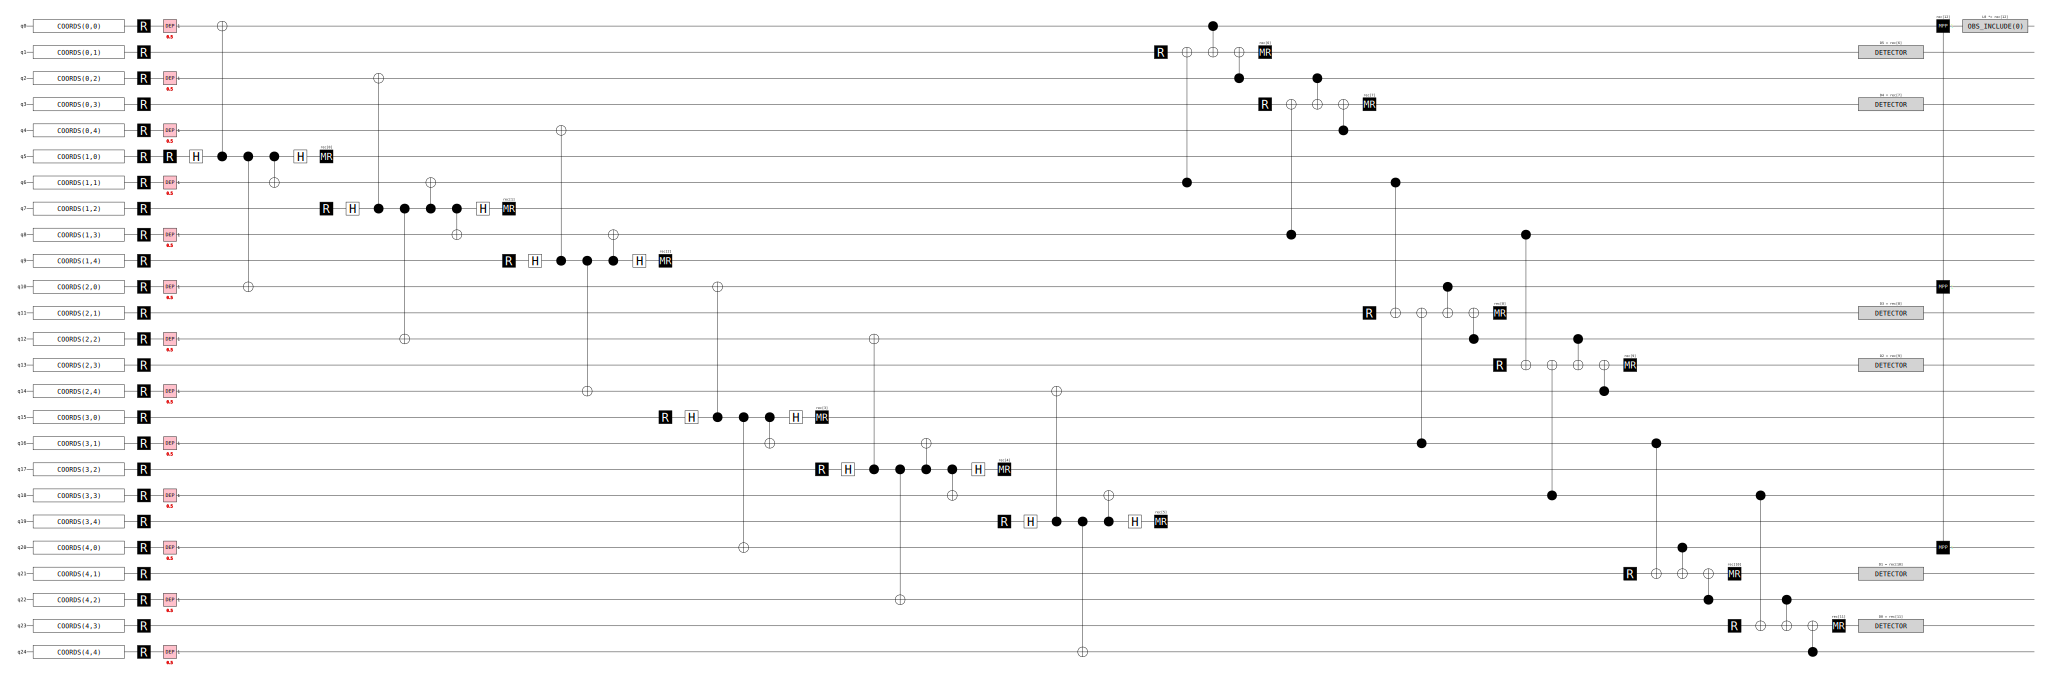

In [108]:
memory_ckt = surface_memory_circuit(3, 0.5)
memory_ckt.diagram('timeline-svg')

In [109]:
sampler = memory_ckt.compile_detector_sampler()
num_true = 0
shots = 100
syndromes_detectors, observables = sampler.sample(shots, separate_observables=True)
for syndrome, obs in zip(syndromes_detectors, observables):
    if obs[0]:
        num_true += 1
    print(binary_np_array_to_str(syndrome), binary_np_array_to_str(obs))
print(f"{num_true}/{shots} Z measurements were True.")

110010 1
000110 0
010010 1
000111 0
101100 0
111100 1
000000 0
001001 0
101100 1
100000 0
011111 0
000100 1
111011 1
001110 0
100001 0
010010 1
111011 0
001101 1
011101 0
001100 0
100011 1
111110 1
010001 0
111000 1
000101 0
010111 0
010101 0
011010 1
011000 0
001101 0
000000 0
010011 0
101001 0
011111 1
010001 0
000001 1
110000 1
001101 0
100110 1
001001 1
011101 1
110101 0
000100 1
011000 0
001111 0
101100 1
010111 0
101110 1
000001 0
100110 0
100000 0
101111 1
000010 1
100110 1
001010 0
110001 1
010011 1
010010 1
101010 0
001100 1
110001 1
110000 0
111001 0
100000 1
111111 0
101111 1
100010 1
000100 1
110001 1
000100 0
010000 0
000001 1
001000 1
011101 0
011000 0
000001 1
100011 0
000011 0
001010 1
011001 1
011110 1
000010 1
111001 0
110010 0
011011 0
101000 0
000011 1
110001 0
101110 1
001110 1
011010 1
010110 1
110101 0
101010 1
010011 0
111001 1
101000 0
000001 1
111010 0
101111 0
49/100 Z measurements were True.


In [110]:
dem = memory_ckt.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.333333) D0
    error(0.333333) D0 D1
    error(0.333333) D0 D2
    error(0.333333) D1 D3
    error(0.333333) D1 L0
    error(0.333333) D2
    error(0.333333) D2 D3
    error(0.333333) D2 D4
    error(0.333333) D3 D5
    error(0.333333) D3 L0
    error(0.333333) D4
    error(0.333333) D4 D5
    error(0.333333) D5 L0
''')


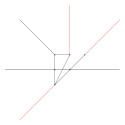

In [111]:
dem.diagram("matchgraph-svg")

In [103]:
shots = 10_000
num_errs = count_logical_errors(memory_ckt, shots)
print(f"Got {num_errs} logical errors out of {shots} shots.")

Got 4704 logical errors out of 10000 shots.


In [104]:
shots = 10_000
noise_rates = np.logspace(log10(0.125), log10(0.2), num=10)
ds = [3, 5, 7]
all_lers = np.zeros((len(ds), len(noise_rates)), dtype=float)
for i, d in enumerate(ds):
    for j, noise in enumerate(noise_rates):
        memory_ckt = surface_memory_circuit(d, noise)
        num_errors = count_logical_errors(memory_ckt, shots)
        ler = float(num_errs) / float(shots)
        all_lers[i, j] = ler

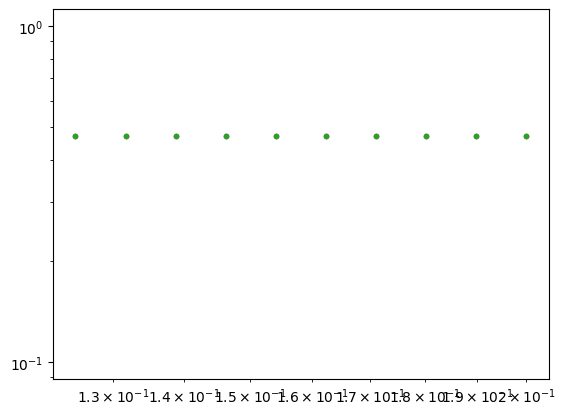

In [105]:
fig, ax = plt.subplots()
ax.plot(noise_rates, all_lers.T, '.')
ax.set_yscale("log")
ax.set_xscale("log")